In [43]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt

# Data Loading

In [44]:
train_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
test_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

batch_size = 32
data_transforms = transforms.Compose([
    transforms.Resize((299, 299)), 
    transforms.ToTensor(),                   
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize with ImageNet stats
                         std=[0.229, 0.224, 0.225])
])


In [45]:
train_dataset_full = datasets.ImageFolder(
    root=train_dir,
    transform=data_transforms
)

test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=data_transforms
)


total_train_size = len(train_dataset_full)
val_size = int(total_train_size * 0.2)
train_size = total_train_size - val_size

train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,  
    num_workers=4  
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4
)


In [46]:
print(train_dataset_full.class_to_idx)
# to see what labels are given for each class

{'FAKE': 0, 'REAL': 1}


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Getting the InceptionV3 model's Embeddings (last but one layer outputs)

In [48]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  

weights = models.Inception_V3_Weights.IMAGENET1K_V1
model = models.inception_v3(weights=weights)

model.fc = nn.Identity() # remove the last layer

model.to(device) 
model.eval()     

def get_embeddings(dataloader, model):
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting embeddings"):
            images = images.to(device)
            
            # In eval mode, InceptionV3 automatically gives one output
            embeddings = model(images)
            
            all_embeddings.append(embeddings.cpu()) #.cpu to free gpu memory
            all_labels.append(labels.cpu())

    # Concatenate all batches into two big tensors
    final_embeddings = torch.cat(all_embeddings, dim=0)
    final_labels = torch.cat(all_labels, dim=0)
    
    return final_embeddings, final_labels


train_embeddings, train_labels = get_embeddings(train_loader, model)
val_embeddings, val_labels = get_embeddings(val_loader, model)
test_embeddings, test_labels = get_embeddings(test_loader, model)

Extracting embeddings: 100%|██████████| 625/625 [01:34<00:00,  6.64it/s]


## Save the obtained Embeddings

In [49]:
torch.save(train_embeddings, 'train_embeddings.pt')
torch.save(train_labels, 'train_labels.pt')

torch.save(val_embeddings, 'val_embeddings.pt')
torch.save(val_labels, 'val_labels.pt')

torch.save(test_embeddings, 'test_embeddings.pt')
torch.save(test_labels, 'test_labels.pt')
print("Done saved")

Done saved


# First thing that comes to mind is FID - Frechet Inception Distance;
#### I had previously used this metric in pix2pix implementation to get semantic similarity between real vs generated image data distributions. Though this is not directly related with this task, it still is a way to calculate how close two distributions are, beyond just pixel level similarity.
#### If FID = 0 (identical distributions)

In [50]:
from scipy.linalg import sqrtm

def calculate_fid(real_embeddings, fake_embeddings):
    mu_real = real_embeddings.mean(0)
    sigma_real = np.cov(real_embeddings, rowvar = False)
    mu_fake = fake_embeddings.mean(0)
    sigma_fake = np.cov(fake_embeddings, rowvar = False)

    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real @ sigma_fake)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff@diff + np.trace(sigma_real + sigma_fake - 2*covmean)
    return fid

In [51]:
real_embeddings = val_embeddings[val_labels == 1]
fake_embeddings = val_embeddings[val_labels == 0]

In [52]:
real_np = real_embeddings.numpy()
fake_np = fake_embeddings.numpy()

In [53]:
fid_score = calculate_fid(real_np, fake_np)
print("FID:", fid_score)

FID: 28.806028175272097


# Different way to capture semantic similarity:

#### using a neural network that takes the learnt embeddings from a pretrained model like inception v3 which is rich of semantic information, and this neural networks learns from the info rich embeddings to classify as real/fake images.
#### thought of upgrading from a simple neural network but since we already use a good pretrained model that captures semantic information from its inputs, I felt that it is enough to rely on.

# Neural Network to output a score- closer to 1->real; closer to 0->fake

In [54]:
class classifier(nn.Module):
    def __init__(self, input_shape, drop_prob = 0.5):
        super().__init__()
        self.linear1 = nn.Linear(input_shape, 256)
        self.dropout = nn.Dropout(p = drop_prob)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.dropout(self.linear1(x)))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

### Load embeddings previously saved

In [55]:
import torch
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64  
train_embeddings = torch.load('train_embeddings.pt')
train_labels = torch.load('train_labels.pt')

val_embeddings = torch.load('val_embeddings.pt')
val_labels = torch.load('val_labels.pt')

test_embeddings = torch.load('test_embeddings.pt')
test_labels = torch.load('test_labels.pt')

In [56]:
train_dataset_embs = TensorDataset(train_embeddings, train_labels)
val_dataset_embs = TensorDataset(val_embeddings, val_labels)
test_dataset_embs = TensorDataset(test_embeddings, test_labels)

In [57]:
train_loader = DataLoader(
    dataset=train_dataset_embs,
    batch_size=batch_size,
    shuffle=True,  
)

val_loader = DataLoader(
    dataset=val_dataset_embs,
    batch_size=batch_size,
    shuffle=False, 
)

test_loader = DataLoader(
    dataset=test_dataset_embs,
    batch_size=batch_size,
    shuffle=False, 
)

In [58]:
model = classifier(2048).to(device)         # 2048 standard size of inception v3's embeddings

## Training the model

In [59]:
from torch.nn import BCEWithLogitsLoss
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score 

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = BCEWithLogitsLoss()
best_val_loss = np.Inf
n_epochs_stop = 5

for epoch in range(10):
    model.train()
    total_loss = 0
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(embeddings)
        
        loss = criterion(outputs, labels.unsqueeze(1).float())
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    print(f"Epoch-{epoch+1}, train-loss = {total_loss / len(train_loader)}")
    
    model.eval()
    total_val_loss = 0 
    all_labels = []    
    all_preds = []     

    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings = embeddings.to(device)
            labels = labels.to(device)
                  
            outputs = model(embeddings) 
            
            loss = criterion(outputs, labels.unsqueeze(1).float())
            total_val_loss += loss.item()
            
            probs = torch.sigmoid(outputs)
            preds = torch.round(probs) 
            
            all_preds.extend(preds.squeeze().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds)

    print(f"val-loss = {avg_val_loss:.4f}")
    print(f"val-accuracy = {val_accuracy:.4f}, val-f1 = {val_f1:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "model.pt")

Epoch-1, train-loss = 0.3325649426460266
val-loss = 0.2687
val-accuracy = 0.8899, val-f1 = 0.8844
Epoch-2, train-loss = 0.2700384006679058
val-loss = 0.2367
val-accuracy = 0.9020, val-f1 = 0.9030
Epoch-3, train-loss = 0.248957634472847
val-loss = 0.2189
val-accuracy = 0.9101, val-f1 = 0.9089
Epoch-4, train-loss = 0.23495191519260405
val-loss = 0.2160
val-accuracy = 0.9112, val-f1 = 0.9081
Epoch-5, train-loss = 0.22365644461512565
val-loss = 0.2193
val-accuracy = 0.9094, val-f1 = 0.9115
Epoch-6, train-loss = 0.21632673656344414
val-loss = 0.2003
val-accuracy = 0.9216, val-f1 = 0.9211
Epoch-7, train-loss = 0.20928859203457834
val-loss = 0.1916
val-accuracy = 0.9242, val-f1 = 0.9240
Epoch-8, train-loss = 0.2046242289721966
val-loss = 0.1923
val-accuracy = 0.9255, val-f1 = 0.9266
Epoch-9, train-loss = 0.19788818410336972
val-loss = 0.1930
val-accuracy = 0.9236, val-f1 = 0.9228
Epoch-10, train-loss = 0.1910458017706871
val-loss = 0.1859
val-accuracy = 0.9258, val-f1 = 0.9267


### Final Evaluation

In [60]:
model.eval()
total_val_loss = 0 
all_labels = []    
all_preds = []     

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
              
        outputs = model(embeddings) 
        
        loss = criterion(outputs, labels.unsqueeze(1).float())
        total_val_loss += loss.item()
        
        probs = torch.sigmoid(outputs)
        preds = torch.round(probs) 
        
        all_preds.extend(preds.squeeze().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


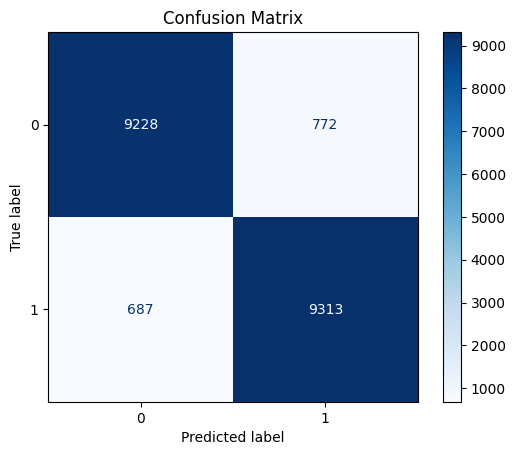

In [61]:
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(all_labels, all_preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

plt.show()

### But still this is not enough as we have to get a "similarity" score
#### so, i thought maybe we could feed in 2 images of any combination, (like (real, real), (fake, fake), (real, fake)) to the inception v3; get the embeddings and pass through the Semantic_similarity neural network to get two score, one for each image, and then we get a final similarity score, which would be between 0 and 1 

In [62]:
def similarity_score(score1, score2):
    return 1 - abs(score1-score2)       # abs(score1-score2) gives how different they are, so similarity = 1-difference

# Final Pipeline:

In [63]:
import torch
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64  
test_embeddings = torch.load('test_embeddings.pt')
test_labels = torch.load('test_labels.pt')

In [64]:
model = classifier(2048).to(device)         
state_dict = torch.load('model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [65]:
all_probs = []
all_labels = []

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)
              
        outputs = model(embeddings) 
        
        probs = torch.sigmoid(outputs)
        
        all_probs.extend(probs.squeeze().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

fake_scores = []
real_scores = []
for i in range(len(all_labels)):
    if all_labels[i] == 0: 
        fake_scores.append(all_probs[i])
    else: 
        real_scores.append(all_probs[i])
    
fake_avg_score = np.mean(fake_scores)
real_avg_score = np.mean(real_scores)
final_similarity_score = similarity_score(fake_avg_score, real_avg_score)

In [66]:
print(final_similarity_score)

0.24686336517333984


### We can see that a lower score means that the two datasets are not similar/ similar by only 24%